In [1]:
import os, sys
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

import utils2p

In [2]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
sys.path.append(MODULE_DIR)

In [3]:
from longterm import load, pipeline, utils

In [4]:
date_dir = join(load.NAS_DIR_JB, "210301_J1xCI9")
fly_dir = load.get_flies_from_datedir(date_dir)[0]
trial_dirs = load.get_trials_from_fly(fly_dir)[0]

In [5]:
default_params = pipeline.PreProcessParams()
denoised_name = default_params.green_denoised
green_denoised_dirs = [utils.find_file(trial_dir, denoised_name) for trial_dir in trial_dirs]
print(green_denoised_dirs)

['/mnt/NAS/JB/210301_J1xCI9/Fly1/001_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/002_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/003_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/004_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/005_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/006_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/007_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/008_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/009_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/010_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/011_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/012_xz/processed/green_denoised.tif']


In [6]:
greens = [utils.get_stack(green) for green in green_denoised_dirs]

In [ ]:
red_name = default_params.red_com_warped
red_dirs = [utils.find_file(trial_dir, red_name) for trial_dir in trial_dirs]
red = [utils.get_stack(red) for red in red_dirs]

In [7]:
green_stds = [np.std(green, axis=0) for green in greens]
green_maxs = [np.max(green, axis=0) for green in greens]
green_total_std = np.mean(np.array(green_stds), axis=0)
green_total_max = np.max(np.array(green_maxs), axis=0)

In [15]:
# copying from nely_suite because of an import error


def local_correlations(Y, eight_neighbours=True, swap_dim=False, order_mean=1):
    """
    This function was copied from CaImAn published in Giovannucci et al. eLife, 2019.
    Computes the correlation image for the input dataset Y
    Args:
        Y:  np.ndarray (3D or 4D)
            Input movie data in 3D or 4D format
    
        eight_neighbours: Boolean
            Use 8 neighbors if true, and 4 if false for 3D data (default = True)
            Use 6 neighbors for 4D data, irrespectively
    
        swap_dim: Boolean
            True indicates that time is listed in the last axis of Y (matlab format)
            and moves it in the front
    Returns:
        rho: d1 x d2 [x d3] matrix, cross-correlation with adjacent pixels
    """

    if swap_dim:
        Y = np.transpose(Y, tuple(np.hstack((Y.ndim - 1, list(range(Y.ndim))[:-1]))))

    rho = np.zeros(np.shape(Y)[1:])
    w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)

    rho_h = np.mean(np.multiply(w_mov[:, :-1, :], w_mov[:, 1:, :]), axis=0)
    rho_w = np.mean(np.multiply(w_mov[:, :, :-1], w_mov[:, :, 1:]), axis=0)

    if order_mean == 0:
        rho = np.ones(np.shape(Y)[1:])
        rho_h = rho_h
        rho_w = rho_w
        rho[:-1, :] = rho[:-1, :] * rho_h
        rho[1:, :] = rho[1:, :] * rho_h
        rho[:, :-1] = rho[:, :-1] * rho_w
        rho[:, 1:] = rho[:, 1:] * rho_w
    else:
        rho[:-1, :] = rho[:-1, :] + rho_h ** (order_mean)
        rho[1:, :] = rho[1:, :] + rho_h ** (order_mean)
        rho[:, :-1] = rho[:, :-1] + rho_w ** (order_mean)
        rho[:, 1:] = rho[:, 1:] + rho_w ** (order_mean)

    if Y.ndim == 4:
        rho_d = np.mean(np.multiply(w_mov[:, :, :, :-1], w_mov[:, :, :, 1:]), axis=0)
        rho[:, :, :-1] = rho[:, :, :-1] + rho_d
        rho[:, :, 1:] = rho[:, :, 1:] + rho_d

        neighbors = 6 * np.ones(np.shape(Y)[1:])
        neighbors[0] = neighbors[0] - 1
        neighbors[-1] = neighbors[-1] - 1
        neighbors[:, 0] = neighbors[:, 0] - 1
        neighbors[:, -1] = neighbors[:, -1] - 1
        neighbors[:, :, 0] = neighbors[:, :, 0] - 1
        neighbors[:, :, -1] = neighbors[:, :, -1] - 1

    else:
        if eight_neighbours:
            rho_d1 = np.mean(np.multiply(w_mov[:, 1:, :-1], w_mov[:, :-1, 1:]), axis=0)
            rho_d2 = np.mean(np.multiply(w_mov[:, :-1, :-1], w_mov[:, 1:, 1:]), axis=0)

            if order_mean == 0:
                rho_d1 = rho_d1
                rho_d2 = rho_d2
                rho[:-1, :-1] = rho[:-1, :-1] * rho_d2
                rho[1:, 1:] = rho[1:, 1:] * rho_d1
                rho[1:, :-1] = rho[1:, :-1] * rho_d1
                rho[:-1, 1:] = rho[:-1, 1:] * rho_d2
            else:
                rho[:-1, :-1] = rho[:-1, :-1] + rho_d2 ** (order_mean)
                rho[1:, 1:] = rho[1:, 1:] + rho_d1 ** (order_mean)
                rho[1:, :-1] = rho[1:, :-1] + rho_d1 ** (order_mean)
                rho[:-1, 1:] = rho[:-1, 1:] + rho_d2 ** (order_mean)

            neighbors = 8 * np.ones(np.shape(Y)[1:3])
            neighbors[0, :] = neighbors[0, :] - 3
            neighbors[-1, :] = neighbors[-1, :] - 3
            neighbors[:, 0] = neighbors[:, 0] - 3
            neighbors[:, -1] = neighbors[:, -1] - 3
            neighbors[0, 0] = neighbors[0, 0] + 1
            neighbors[-1, -1] = neighbors[-1, -1] + 1
            neighbors[-1, 0] = neighbors[-1, 0] + 1
            neighbors[0, -1] = neighbors[0, -1] + 1
        else:
            neighbors = 4 * np.ones(np.shape(Y)[1:3])
            neighbors[0, :] = neighbors[0, :] - 1
            neighbors[-1, :] = neighbors[-1, :] - 1
            neighbors[:, 0] = neighbors[:, 0] - 1
            neighbors[:, -1] = neighbors[:, -1] - 1

    if order_mean == 0:
        rho = np.power(rho, 1.0 / neighbors)
    else:
        rho = np.power(np.divide(rho, neighbors), 1 / order_mean)

    return rho

In [7]:
# copy from nely_suite
import cv2
def average_signal_in_rois(stack, mask):

    n_rois = len(np.unique(mask))-1
    signals = np.zeros((n_rois, stack.shape[0]))
    for i_roi, roi_num in enumerate(np.unique(mask)[1:]):
        mask_one_roi = np.where(mask == roi_num)
        for i, j in zip(mask_one_roi[0], mask_one_roi[1]):
            signals[i_roi] = signals[i_roi] + stack[:, i, j]
        signals[i_roi] /= len(mask_one_roi[0])

    return signals

def get_dff_traces(stack, mask, min_size=0, length_baseline=10, connectivity=4):
    """
    Extract traces for individual neurons for a given mask with non overlapping connected components.
    Parameters
    ----------
    stack : numpy array
        Image stack with fluorescence values. First dimension is time.
    mask : numpy array
        Image from in which neurons are painted and background is black.
    min_size : int, optional
        Minimum size for a connected component to be considered.
        Default is 0.
    length_baseline : int, optional
        Length of the baseline used to compute dF/F.
        Default is 10.
    connectivity : 4 or 8
        Connectivity for finding connected components. Can be 4-way or 8-way.
    Returns
    -------
    dff_traces : numpy array
        First dimension encodes neuron number. Second dimension is time.
    """
    signals = average_signal_in_rois(
        stack, mask, min_size=min_size, connectivity=connectivity
    )
    return get_dff_from_traces(signals, length_baseline=length_baseline)

def get_dff_from_traces(signals, length_baseline=10, return_f0=False, f0_min=None):
    """
    Extract traces for individual neurons for a given mask with non overlapping connected components.
    Parameters
    ----------
    stack : numpy array
        Image stack with fluorescence values. First dimension is time.
    mask : numpy array
        Image from in which neurons are painted and background is black.
    min_size : int, optional
        Minimum size for a connected component to be considered.
        Default is 0.
    length_baseline : int, optional
        Length of the baseline used to compute dF/F.
        Default is 10.
    connectivity : 4 or 8
        Connectivity for finding connected components. Can be 4-way or 8-way.
    Returns
    -------
    dff_traces : numpy array
        First dimension encodes neuron number. Second dimension is time.
    """
    dff = np.zeros_like(signals)
    f_0s = np.zeros((signals.shape[0]))
    for roi_num in range(signals.shape[0]):
        convolved = np.convolve(
            signals[roi_num], np.ones(length_baseline), mode="valid"
        )
        f_0 = np.min(convolved) / length_baseline
        f_0 = np.maximum(f_0, f0_min) if f0_min is not None else f_0
        f_0s[roi_num] = f_0
        dff[roi_num] = (signals[roi_num] - f_0) / f_0
    return dff if not return_f0 else (dff, f_0s)

In [16]:
# import nely_suite
green_local_corrs = [local_correlations(green) for green in greens]  # ely_suite.signals.
green_total_local_corr = np.mean(np.array(green_local_corrs), axis=0)

<IPython.core.display.Javascript object>


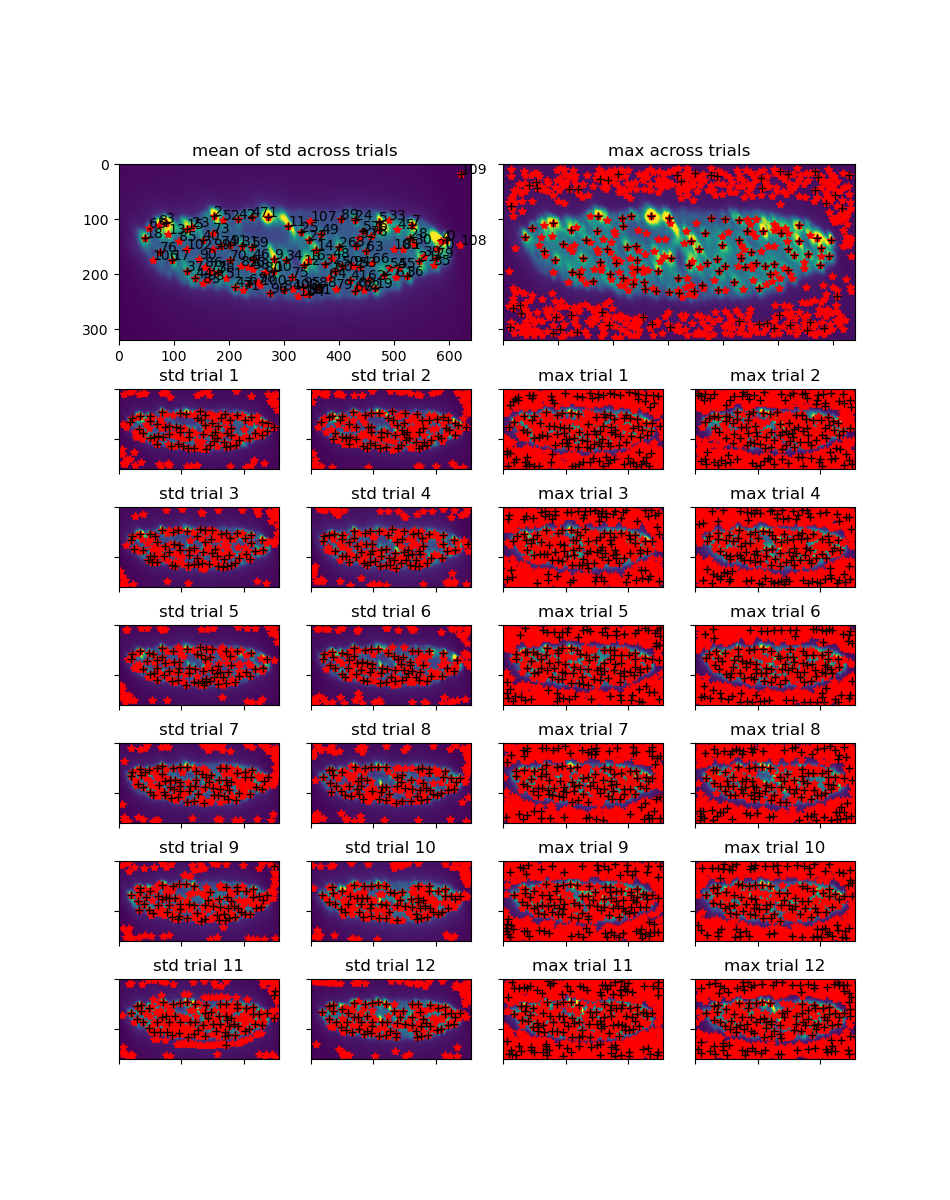

In [25]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True

fig = plt.figure(figsize=(9.5, 12))  # contstained_layout=True)
layout = """
    AABB
    AABB
    CDEF
    GHIJ
    KLMN
    OPQR
    STUV
    WXYZ
    """
axs_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)
for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[ax_name].set_xticklabels([])
        ax_dict[ax_name].set_yticklabels([])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    else:
        i_row = (i_ax - 2) // 4
        i_col = (i_ax - 2) % 4
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            im = green_stds[i_trial]
            title = "std trial {}".format(i_trial + 1)
        else:
            i_trial = i_row * 2 + i_col - 2
            im = green_maxs[i_trial]
            title = "max trial {}".format(i_trial + 1)
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)
    
    if SHOW_MAX:
        coordinates5 = peak_local_max(im, min_distance=5)
        coordinates10 = peak_local_max(im, min_distance=10)
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax == 0:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
    

In [26]:
coordinates5_total_std = peak_local_max(green_total_std, min_distance=5)
for i_c, coord in enumerate(coordinates5):
    print("{:3}: {:3}, {:3}".format(i_c, coord[0], coord[1]))

  0:  94, 269
  1:  98, 301
  2: 138, 595
  3: 140, 537
  4: 135, 561
  5: 106,  91
  6: 111, 537
  7: 128, 557
  8: 119, 123
  9: 153, 356
 10: 140, 573
 11: 152, 577
 12: 109,  75
 13: 117, 481
 14: 114, 133
 15: 123, 476
 16: 106, 476
 17: 183, 338
 18:  95, 175
 19: 176, 344
 20: 174, 284
 21: 170, 145
 22: 135, 347
 23: 195, 284
 24: 101, 429
 25: 101, 188
 26: 151, 225
 27: 157, 275
 28: 169, 305
 29: 135, 337
 30: 164, 528
 31: 180, 305
 32: 153, 517
 33: 150, 403
 34: 131,  89
 35: 224, 467
 36: 135,  45
 37: 119, 492
 38: 187, 357
 39: 141, 157
 40: 199, 195
 41: 173, 101
 42: 208, 196
 43: 115, 510
 44: 209, 422
 45: 180, 570
 46: 192, 517
 47: 118, 521
 48: 145, 328
 49: 159, 451
 50: 164, 544
 51: 200, 521
 52: 185, 476
 53: 200, 485
 54: 206, 525
 55: 173, 354
 56: 212, 163
 57:  97, 216
 58: 203, 397
 59: 174, 244
 60: 137, 149
 61: 181, 402
 62: 186, 547
 63: 169, 573
 64: 218, 236
 65: 200, 138
 66: 181, 492
 67: 210, 225
 68: 174, 457
 69: 179, 206
 70: 171, 204
 71: 1

In [27]:
confirmed_ROIs = [18, 65, 8, 3, 13, 23, 40, 2, 52, 73, 74, 91, 31, 59, 42, 47, 1, 11, 25, 22, 14, 49, 26, 24, 89, 57, 63, 78, 5, 6,33, 45, 
                  7, 28, 30, 81, 4, 0, 20, 29, 21, 39, 35, 27, 36, 55, 54, 61, 19, 62, 41, 53, 50, 72, 68, 79, 69, 66, 94, 60, 16, 12,
                 32, 88, 48, 64, 95, 97, 103, 10, 96, 84, 104, 75, 80, 43, 71, 67, 100, 82, 56, 58, 51, 38, 37, 44, 86, 77, 90, 17, 76, 106,
                 87, 9, 34, 46, 70, 99]
additional_ROIs = [[137, 38],
                   [108, 120], 
                   [126, 125],
                   [98, 298],
                   [94, 285],
                   [112, 481],
                   [145, 529],
                   [138, 561],
                   [126, 555],
                   [105, 551], 
                   [131, 572],
                   [164, 590],
                   [182, 555],
                   [173, 564],
                   [214, 490],
                   [206, 397],
                   [188, 355],
                   [208, 224],
                   [212, 129],
                   [219, 153],
                   [212, 164],
                   [175, 79],
                   [200, 91],
                  [152, 274],
                  [162, 293]]

In [28]:
new_ROIs = np.vstack((coordinates5_total_std[confirmed_ROIs, :], additional_ROIs))
for i_c, coord in enumerate(new_ROIs):
    print("{:3}: {:3}, {:3}".format(i_c, coord[0], coord[1]))

  0: 134,  48
  1: 115,  54
  2: 110,  73
  3: 106,  85
  4: 127,  89
  5: 113, 133
  6: 138, 152
  7:  93, 173
  8: 102, 189
  9: 124, 171
 10: 149, 186
 11: 147, 202
 12: 149, 224
 13: 150, 242
 14: 100, 216
 15:  95, 241
 16:  95, 271
 17: 112, 308
 18: 123, 331
 19: 138, 345
 20: 155, 358
 21: 127, 367
 22: 150, 400
 23: 102, 428
 24: 100, 403
 25: 122, 444
 26: 158, 449
 27: 130, 458
 28: 104, 473
 29: 119, 472
 30: 102, 491
 31: 117, 505
 32: 111, 532
 33: 134, 529
 34: 144, 537
 35: 153, 516
 36: 139, 585
 37: 137, 595
 38: 153, 578
 39: 170, 576
 40: 175, 546
 41: 166, 554
 42: 183, 573
 43: 201, 481
 44: 203, 523
 45: 188, 508
 46: 188, 492
 47: 205, 503
 48: 225, 466
 49: 211, 452
 50: 210, 420
 51: 187, 438
 52: 185, 405
 53: 228, 445
 54: 231, 429
 55: 227, 395
 56: 222, 435
 57: 179, 460
 58: 185, 425
 59: 193, 392
 60: 174, 345
 61: 182, 336
 62: 181, 374
 63: 223, 363
 64: 171, 387
 65: 207, 382
 66: 223, 335
 67: 235, 345
 68: 227, 316
 69: 193, 282
 70: 233, 275
 71: 2

<IPython.core.display.Javascript object>


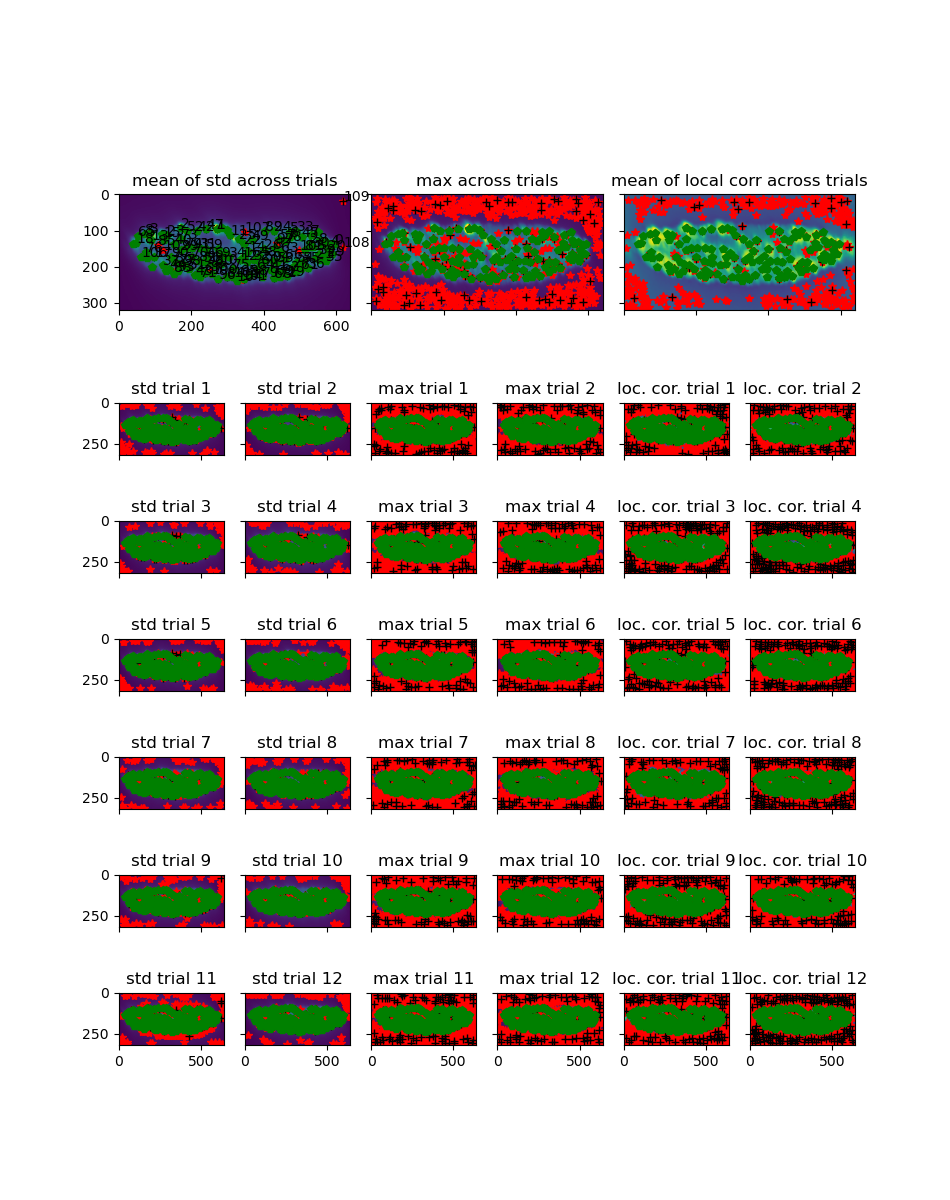

In [29]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
"""
def on_click(event):
    if event.inaxes is not None:
        print(event.ydata, event.xdata)
    else:
        print('Clicked ouside axes bounds but inside plot window')
"""
fig = plt.figure(figsize=(9.5, 12))  # contstained_layout=True)
# fig.canvas.callbacks.connect('button_press_event', on_click)

layout = """
    AABBCC
    AABBCC
    DEFGHI
    JKLMNO
    PQRSTU
    VWXYZa
    bcdefg
    hijklm
    """
axs_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklm"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)
for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])

        if (i_ax - 3) % 6:
            ax_dict[ax_name].set_yticklabels([])
        if not (i_ax - 3) >= 6*5:
            ax_dict[ax_name].set_xticklabels([])
        
        

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    elif i_ax == 2:
        im = green_total_local_corr
        title = "mean of local corr across trials"
    else:
        i_row = (i_ax - 3) // 6
        i_col = (i_ax - 3) % 6
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            im = green_stds[i_trial]
            title = "std trial {}".format(i_trial + 1)
        elif i_col < 4:
            i_trial = i_row * 2 + i_col - 2
            im = green_maxs[i_trial]
            title = "max trial {}".format(i_trial + 1)
        else:
            i_trial = i_row * 2 + i_col - 4
            im = green_local_corrs[i_trial]
            title = "loc. cor. trial {}".format(i_trial + 1)
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)
    
    if SHOW_MAX:
        coordinates5 = peak_local_max(im, min_distance=5)
        coordinates10 = peak_local_max(im, min_distance=10)
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax == 0:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
                
    _ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in new_ROIs]


<IPython.core.display.Javascript object>


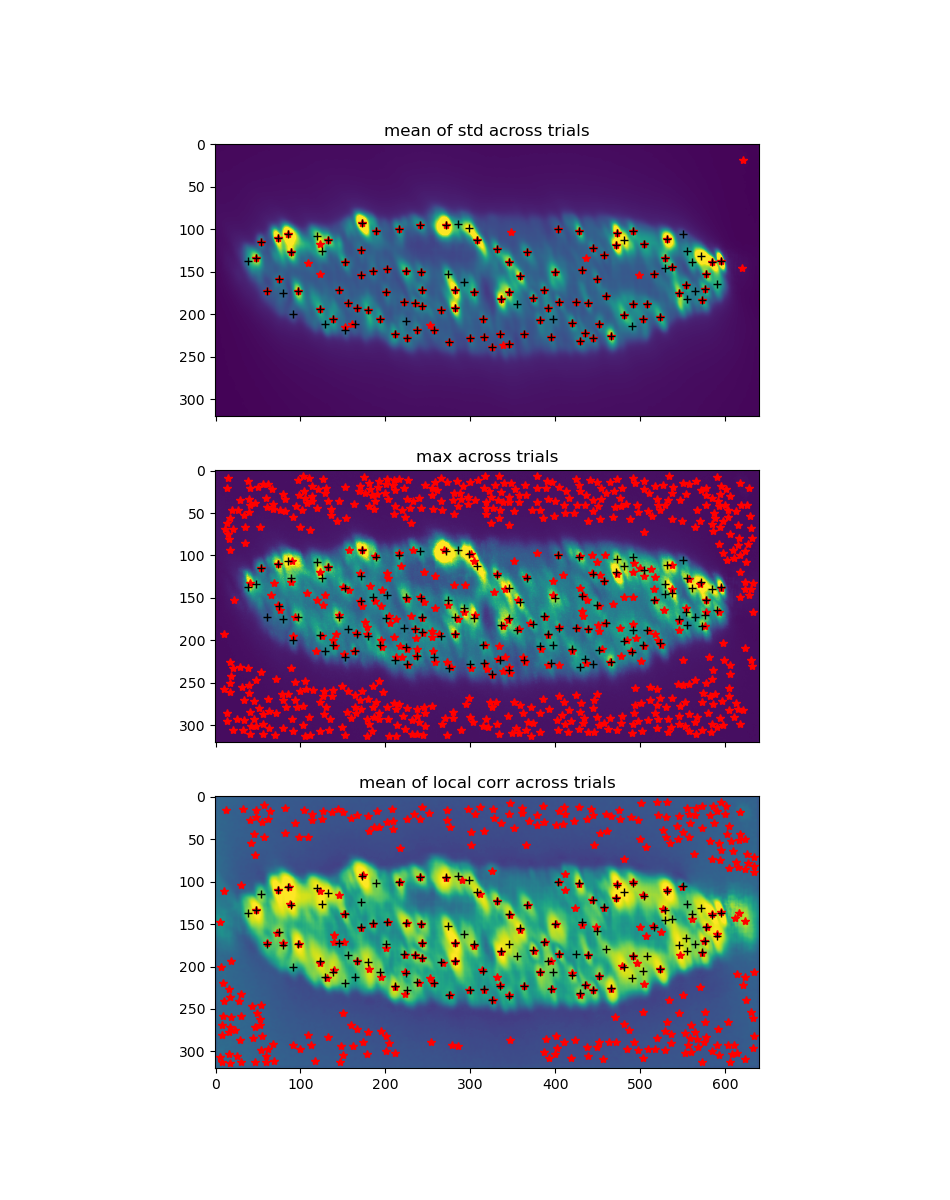

In [50]:
%matplotlib notebook
quantile = 0.99
"""
def on_click(event):
    if event.inaxes is not None:
        print(event.ydata, event.xdata)
    else:
        print('Clicked ouside axes bounds but inside plot window')
"""
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9.5, 12), sharex=True, sharey=True)
        
        

for i_ax, ax in enumerate(axs):
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    elif i_ax == 2:
        im = green_total_local_corr
        title = "mean of local corr across trials"
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)

    coordinates5 = peak_local_max(im, min_distance=5)
    _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
    _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in new_ROIs]
    if i_ax == -1:
        for i in range(len(new_ROIs)):
            ax.annotate(str(i), np.flip(new_ROIs[i]))
                



# extract ROI signals

In [8]:
roi_centers_file = os.path.join(fly_dir, load.PROCESSED_FOLDER, "ROI_centers.txt")
with open(roi_centers_file, 'r') as file:
    roi_centers_text = file.readlines()
roi_centers = []
for line in roi_centers_text:
    roi_centers.append([int(line[5:8]), int(line[-4:-1])])
N_rois = len(roi_centers)
print("Read the centers of {} ROIs from file".format(N_rois))

Read the centers of 123 ROIs from file


In [9]:
def get_roi_signal(stack, center=None, size=[0, 0], mask=None, pattern=None):
    if not center is None and size == [0, 0] and pattern is None:
        return stack[:, center[0], center[1]]
    elif not center is None:
        return np.mean(stack[:, center[0]-size[0]:center[0]+size[0], center[1]-size[1]:center[1]+size[1]], axis=(1, 2))
    elif not mask is None:
        return np.mean(stack[:, mask], axis=(1,2))
    elif pattern is not None:
        if pattern=="default":
            pattern = np.array(
                [[0, 0, 0, 1, 0, 0, 0],# 1
                 [0, 0, 1, 1, 1, 0, 0],# 2
                 [0, 1, 1, 1, 1, 1, 0],# 3
                 [0, 1, 1, 1, 1, 1, 0],# 4
                 [1, 1, 1, 1, 1, 1, 1],# 5
                 [1, 1, 1, 1, 1, 1, 1],# 6
                 [1, 1, 1, 1, 1, 1, 1],# 7
                 [0, 1, 1, 1, 1, 1, 0],# 8
                 [0, 1, 1, 1, 1, 1, 0],# 9
                 [0, 0, 1, 1, 1, 0, 0],# 10
                 [0, 0, 0, 1, 0, 0, 0]]# 11
                )#1, 2, 3, 4, 5, 6, 7
        pshape = pattern.shape
        raise NotImplementedError
    else:
        raise(NotImplementedError)

In [10]:
from skimage.segmentation import watershed

In [17]:
centers = np.zeros_like(green_total_local_corr)
for i_c, roi_center in enumerate(roi_centers):
    centers[roi_center[0], roi_center[1]] = i_c + 1
    

In [18]:
ROI_shape = np.array(
    [[0, 0, 0, 1, 0, 0, 0],# 1
     [0, 0, 1, 1, 1, 0, 0],# 2
     [0, 1, 1, 1, 1, 1, 0],# 3
     [0, 1, 1, 1, 1, 1, 0],# 4
     [1, 1, 1, 1, 1, 1, 1],# 5
     [1, 1, 1, 1, 1, 1, 1],# 6
     [1, 1, 1, 1, 1, 1, 1],# 7
     [0, 1, 1, 1, 1, 1, 0],# 8
     [0, 1, 1, 1, 1, 1, 0],# 9
     [0, 0, 1, 1, 1, 0, 0],# 10
     [0, 0, 0, 1, 0, 0, 0]]# 11
    )#1, 2, 3, 4, 5, 6, 7
print(np.sum(ROI_shape), np.shape(ROI_shape))

49 (11, 7)


<IPython.core.display.Javascript object>


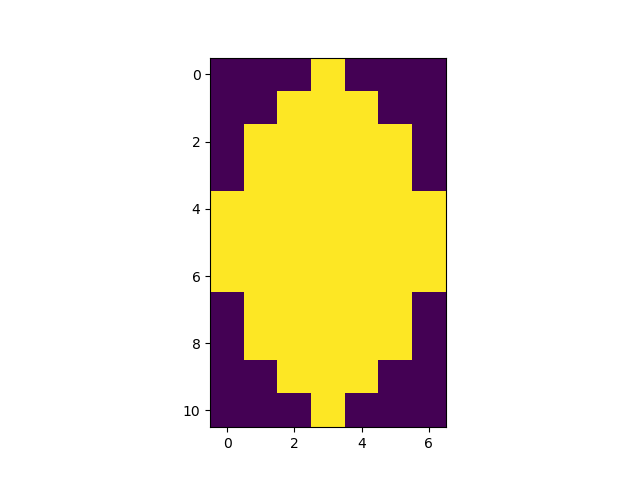

In [19]:
%matplotlib notebook
plt.imshow(ROI_shape)

In [20]:
from scipy.ndimage.filters import convolve
centers_convolved = convolve(centers, ROI_shape)

<IPython.core.display.Javascript object>


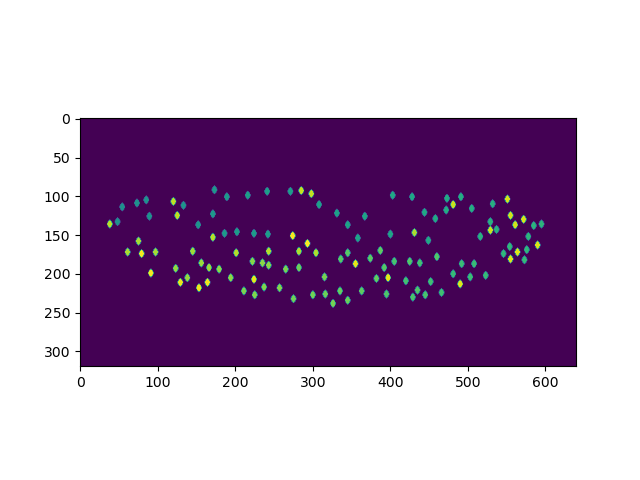

In [29]:
%matplotlib notebook
centers_convolved_add = centers_convolved
centers_convolved_add[centers_convolved_add>0] += 100
plt.imshow(centers_convolved)

In [22]:
np.unique(centers_convolved)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123.])

In [85]:
roi_masks = watershed(green_total_local_corr, markers=centers, watershed_line=True,   # green_total_local_corr
                      mask=green_total_local_corr > np.quantile(green_total_local_corr, 0.95))  # mask=roi_mask, 

<IPython.core.display.Javascript object>


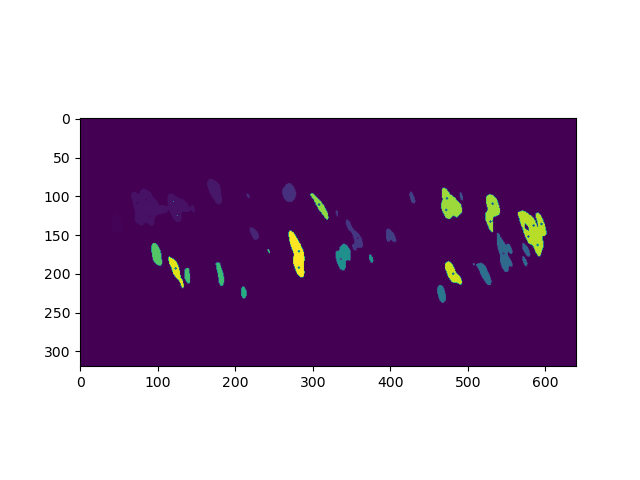

In [86]:
%matplotlib notebook
plt.imshow(roi_masks)

In [23]:
ROI_signals = [average_signal_in_rois(green, mask=centers_convolved) for green in greens]

In [24]:
import pickle

In [27]:
roi_signals_file = os.path.join(fly_dir, load.PROCESSED_FOLDER, "ROI_signals.pkl")
with open(roi_signals_file, "wb") as f:
    pickle.dump(ROI_signals, f)


In [32]:
ROI_signals_total = np.concatenate(ROI_signals, axis=-1)

<IPython.core.display.Javascript object>


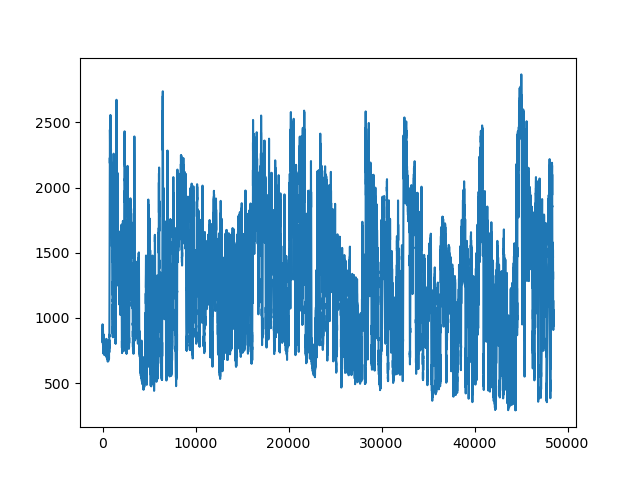

In [132]:
%matplotlib notebook
plt.plot(ROI_signals_total.T[:, 0])

In [33]:
dff_signals_total, f0 = get_dff_from_traces(ROI_signals_total, length_baseline=20, return_f0=True, f0_min=100)

<IPython.core.display.Javascript object>


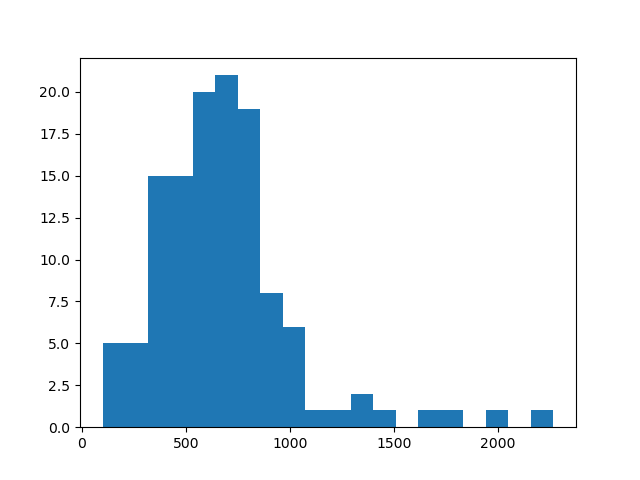

(array([ 5.,  5., 15., 15., 20., 21., 19.,  8.,  6.,  1.,  1.,  2.,  1.,
         0.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([ 100.        ,  208.28131155,  316.56262309,  424.84393464,
         533.12524618,  641.40655773,  749.68786928,  857.96918082,
         966.25049237, 1074.53180391, 1182.81311546, 1291.094427  ,
        1399.37573855, 1507.6570501 , 1615.93836164, 1724.21967319,
        1832.50098473, 1940.78229628, 2049.06360783, 2157.34491937,
        2265.62623092]),
 <BarContainer object of 20 artists>)

In [159]:
%matplotlib notebook
plt.hist(f0, bins=20)

In [35]:
dff_signals = [dff_signals_total[:, i_trial*4040:(i_trial+1)*4040] for i_trial in range(12)]

<IPython.core.display.Javascript object>


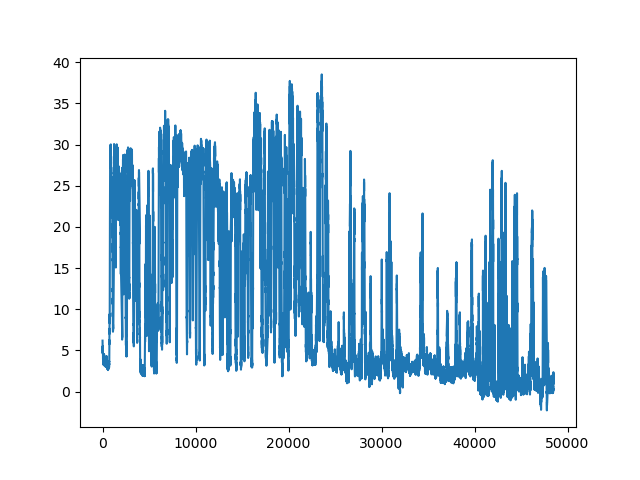

In [161]:
%matplotlib notebook
plt.plot(dff_signals_total.T[:, 36])

<IPython.core.display.Javascript object>


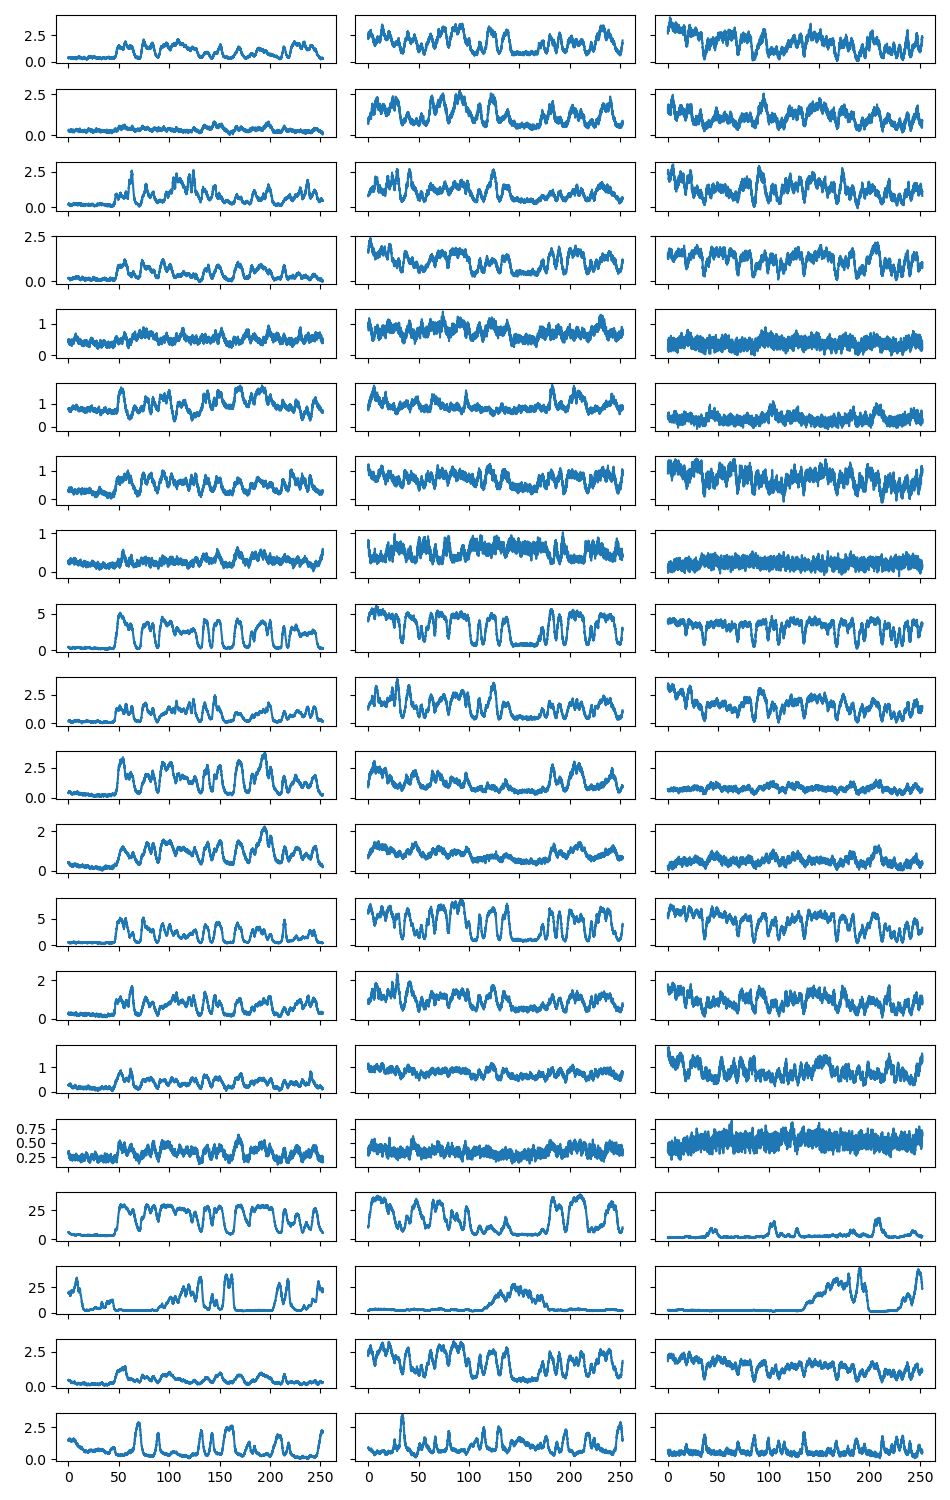

In [39]:
%matplotlib notebook

t = np.arange(4040) / 16

N_rows = 20
N_offset = 20  # 103  # 100  # 80  # 60  # 40  # 20

fig, axs = plt.subplots(nrows=N_rows, ncols=3, figsize=(9.5, 15), sharex=True, sharey="row")
for i_row, _axs in enumerate(axs):
    i_roi = N_offset + i_row
    for i_col, ax in enumerate(_axs):
        if i_col == 0:
            i_trial = 0
        elif i_col == 1:
            i_trial = 5
        else:
            i_trial = 9
        ax.plot(t, dff_signals[i_trial][i_roi, :])
                # get_roi_signal(greens[i_trial], center=roi_centers[i_roi], size=[3,2]))
                                  # mask=centers_convolved==i_roi))
plt.tight_layout()

# Make dff video

In [49]:
from tqdm import tqdm

In [55]:
def make_roi_dff_video_data(roi_dff_signals, roi_mask):
    N_y, N_x = roi_mask.shape
    N_frames, N_rois = roi_dff_signals.shape
    assert len(np.unique(roi_mask)) - 1 == N_rois
    
    dff_video = np.zeros((N_frames, N_y, N_x))
    for i_roi, roi in enumerate(tqdm(np.unique(roi_mask)[1:])):
        for i_frame in np.arange(N_frames):
            dff_video[i_frame, roi_mask==roi] = roi_dff_signals[i_frame, i_roi]
            
    return dff_video

In [56]:
my_dff_video = make_roi_dff_video_data(dff_signals[8].T, centers_convolved)

100%|██████████| 123/123 [02:03<00:00,  1.01s/it]


In [57]:
my_dff_video.shape

(4040, 320, 640)

<IPython.core.display.Javascript object>


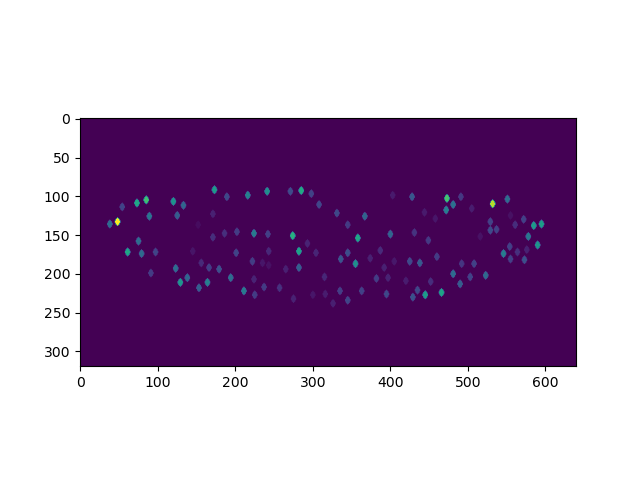

In [59]:
%matplotlib notebook
plt.imshow(my_dff_video[100,::])

In [60]:
import utils2p

In [62]:
dff_out_dir = os.path.join(fly_dir, load.PROCESSED_FOLDER, "dff_rois_007.tif")
utils2p.save_img(dff_out_dir, my_dff_video)


In [63]:
from longterm.plot import videos

<IPython.core.display.Javascript object>


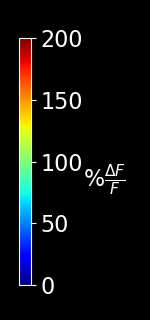

4040it [00:23, 172.31it/s]


In [65]:
dff_mp4_out_dir = os.path.join(fly_dir, load.PROCESSED_FOLDER)
videos.make_video_dff(dff=my_dff_video*100, out_dir=dff_mp4_out_dir, video_name="dff_rois_007", frame_rate=None, trial_dir=trial_dirs[8],
                     vmin=0, vmax=200)